<img src="data/Casino1.jpg"> $\quad \quad \quad $  *Credit: [Japan Times](https://www.japantimes.co.jp/news/2017/11/10/national/japans-casinos-work-keep-yakuza-deal-problem-drinking-experts/#.W-RJPJMzaUk).*


# **Practical session: MCMC algorithms** (Geneviève Robin, Inria Paris)

This practical session will consist of three parts. 
- In the first part, we experiment two Monte-Carlo Markov-Chain algorithms to sample from probability distributions with unknown normalizing constants: Randow-walk Metropolis-Hastings (RWMH) and the Metropolis adjusted Langevin algorithm (MALA). We will also study the discretization of the overdamped Langevin dynamics.
- In the second part, we experiment how these algorithms can be used to compute empirical averages (empirical mean, etc.), and a Central Limit Theorem (CLT) for such averages. 
- Finally in the third part, we experiment the Hamiltonian dynamics and an MCMC algorithm based on it: the Generalized Hamiltonian Monte Carlo (GHMC) algorithm.

# 1. MCMC Sampling algorithms

## 1.1. Random walk Metropolis-Hastings algorithm (RWMH)


The Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult. For instance, when the normalizing constant of the probability distribution is intractable.

The goal is to generate samples according to a probability measure $\nu(q)\propto \exp(-\beta V(q))$, where $q$ denotes the position, $\beta = (k_B T)^{-1}$, and $V$ is a potential function. Recall that the Metropolis-Hastings algorithm produces a Markov Chain $q^1,\ldots q^n, \ldots$ iteratively as follows:


*   Given $q^n$, propose a position $\tilde{q}^{n+1}$ according to transition probability $T(q^n, \tilde{q}^{n+1})$
*   Accept the proposed position with probability $\min(1,r(q^n, \tilde{q}^{n+1}))$, where
$$r(q^n, \tilde{q}^{n+1}) = \frac{\nu(\tilde{q}^{n+1})T(\tilde{q}^{n+1}, q^n)}{\nu({q}^{n})T(q^n,\tilde{q}^{n+1})}.$$

In the simplest setting, the proposals are generated through a random walk with Gaussian steps:
$$\tilde{q}^{n+1} = q^n + \sigma G_n,$$
where $G_n\sim\mathcal{N}(0, Id)$, and $\sigma$ is the standard deviation of the Gaussian displacements. In this case, $T(\tilde{q}^{n+1},q^n)=T(q^n,\tilde{q}^{n+1})$, and thus we simply have $r(q^n, \tilde{q}^{n+1}) = \nu(\tilde{q}^{n+1})/\nu(q^n)$.


Consider the double-well potential function defined by
$$V(q) = (q^2-1)^2 + \frac{1}{\sqrt{2\pi w}}\exp\left(-\frac{(q-c)^2}{2w}\right),$$
$a\geq 0$. The energy landscape associated with this potential is represented using the code below.


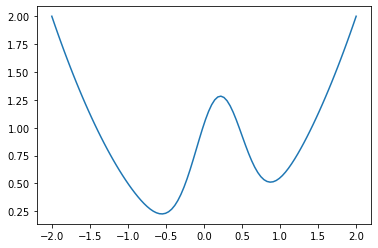

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import math

center=0.2
width=0.1
magn=1

def V(q):
  return 0.5*q**2 + magn*math.exp(-(q-center)**2/(2*width))/math.sqrt(2*math.pi*width)

q=np.linspace(-2, 2,100)
plt.plot(q, list(map(V, q)))



The corresponding probability distribution is defined as follows:
$$\nu(q) =\frac{1}{Z_{\nu}} \exp(-\beta V(q)),$$
where $Z_{\nu}$ is an **unknown** normalization constant. The shape of the probability distribution is represented using the code below.

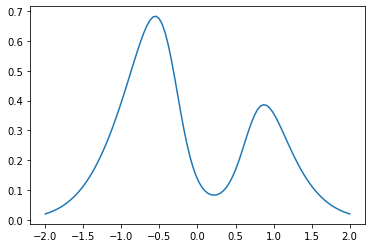

In [43]:
import scipy.integrate as integrate

beta=2

def nu(q):
  return math.exp(-beta*V(q))

Z = integrate.quad(lambda q: nu(q), -10, 10)[0]

def nu_normed(q):
  return math.exp(-beta*V(q))/Z

q=np.linspace(-2,2,100)
plt.plot(q, list(map(nu_normed, q)))

Note that, in this 1-D example, we can compute the normalization constant using a quadrature method. However, in general, such procedures are intractable, either because the parameter space (the dimension of $q$) is too large, or because the probability $\mu$ is defined through the product of a large number of terms (empirical likelihood). Thus, in this lab, we seek to sample $\mu$ as though $Z_{\mu}$ was unknown.


Let us now implement a function which, from the current position $q^n$, returns the new position $q^{n+1}$. Recall that this necessitates two steps: a proposal step and an accept/reject step.
The code is given in the code below, for a given current position $q$ and a given variance of the random walk $\sigma$.

In [0]:
def step_mh(q, sigma):
  q_tilde = q+sigma*np.random.normal(size=1)
  r = min(1, nu(q_tilde)/nu(q))
  u = np.random.uniform()
  if u<r:
    q_next = q_tilde
  else:
    q_next=q
  return q_next


Then, applying the Metropolis-Hastings algorithm boils down to repeating this step for N iterations, from a given starting point $q^0$. Below is the code to perform N iterations of the RMWH algorithm. Two plots are output: on the left, the position $q$ in function of the iterations; on the right, the histogram of the sequence $q^0,\ldots, q^N$, superimposed with the (unknown) target density $\mu$.

**Question 1:** Run the code below for different values of $\sigma$. What do you observe ?

**Question 2:** Replace the Gaussian displacement by a uniform displacement in $[-1,1]$. What do you observe ?


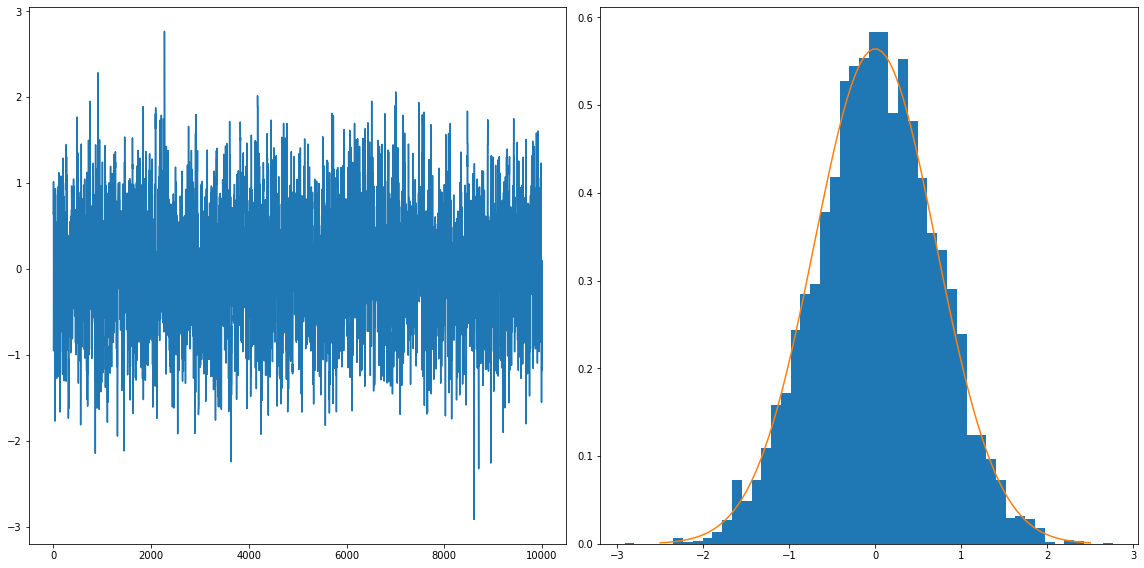

In [29]:
q0 = np.random.uniform()
q=q0
sigma = 1
N = 10000
qtrace = np.zeros((N,1))
for n in range(N):
  q = step_mh(q, sigma)
  qtrace[n]=q
      
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].plot(qtrace)
axes[1].hist(qtrace, bins=50, density=True)
q=np.linspace(-2.5,2.5,100)
axes[1].plot(q, list(map(nu_normed, q)))
fig.tight_layout()


## 1.2. Metropolis adjusted Langevin algorithm (MALA)

In the RWMH algorithm, we proposed moves according to random Gaussian displacements. However, such moves can be inefficient, because they are not informed by the local shape of probability distribution. When information about the potential $V$ are available, they can be used to propose more informed positions: this is the idea behind the MALA algorithm.

The MALA algorithm corresponds in fact to a Metropolis-Hastings algorithm, where the new steps are proposed using an overdamped Langevin dynamic instead of Gaussian displacements. Intuitievly, the Langevin dynamics drives the random walk towards regions of high probability. The proposal $\tilde{q}^{n+1}$ writes, given the current position $q^n$:
$$\tilde{q}^{n+1} = q^n - \Delta t \nabla V(q^n) + \sqrt{\frac{2\Delta t}{\beta}}G^n,$$
where $G_n\sim\mathcal{N}(0, Id)$. 

As before, this proposal step is complemented by an acceptance-rejection step, where the proposed position $\tilde{q}^{n+1}$ is accepted with probability $\min(1,r(q^n, \tilde{q}^{n+1}))$, where
$$
r(q^n, \tilde{q}^{n+1}) = \frac{\nu(\tilde{q}^{n+1})T(\tilde{q}^{n+1}, q^n)}{\nu({q}^{n})T(q^n,\tilde{q}^{n+1})}.
$$

Recall that, in the RWMH algorithm, $T(\tilde{q}^{n+1},q^n)=T(q^n,\tilde{q}^{n+1})$, and thus $r(q^n, \tilde{q}^{n+1}) = \nu(\tilde{q}^{n+1})/\nu(q^n)$. However, this is no longer the case in MALA:
$$T(q^n,\tilde{q}^{n+1}) = \sqrt{\frac{\beta}{4\pi \Delta t}} \exp\left(-\beta\frac{|\tilde{q}^{n+1}-q^n+\Delta t\nabla V(q)|^2}{4 \Delta t}\right),$$

$$T(\tilde{q}^{n+1}, q^n) = \sqrt{\frac{\beta}{4\pi \Delta t}} \exp\left(-\beta\frac{|q^n-\tilde{q}^{n+1}+\Delta t\nabla V(\tilde{q}^{n+1})|^2}{4 \Delta t}\right).$$

Below, the function step_mala implements one step of the MALA algorithm. From a given position $q$ a given timestep $\Delta t$, and a given parameter $\beta$, it outputs the new position according to a Langevin proposal followed by an acceptance-rejection step.


In [0]:
def gradV(q):
    return q - magn*(q-center)/width*math.exp(-(q-center)**2/(2*width))/math.sqrt(2*math.pi*width)#(4*q*(q**2-1) + a)


def step_mala(q, dt, beta):
  reject=False
  G=np.random.normal(size=1)
  q_tilde = q-dt*gradV(q)+math.sqrt(2*dt/beta)*G
  log_r = beta*(V(q)-V(q_tilde))
  Gtilde2 = beta*(q-q_tilde+dt*gradV(q_tilde))**2/(2*dt)
  log_r=log_r + (G**2-Gtilde2)/2
  u = math.log(np.random.uniform())
  if u<=log_r:
    q_next = q_tilde
  else:
    q_next=q
    reject=True
  return q_next,reject

Then, applying the MALA algorithm boils down to repeating this step for N iterations, from a given starting point $q^0$. Below is the code to perform N iterations of the MALA algorithm. As before, two plots are output: on the left, the position $q$ in function of the iterations; on the right, the histogram of the sequence $q^0,\ldots, q^N$, superimposed with the (unknown) target density $\nu$.

**Question 3:** Run the code below for increasing values of $\sigma$. What do you observe ?

**Question 4:** Run the code below for increasing values of $\beta$. What happens ?

**Question 5:** Compute the rejection rate as a function of $\Delta t$, and check that it scales as a power of $\Delta t$ for $\Delta t$ small (which power?). Compare with the rejection rate for RWMH (you first need to implement some rejection count in RWMH, as done below for MALA). 


Average rejection rate 0.0073


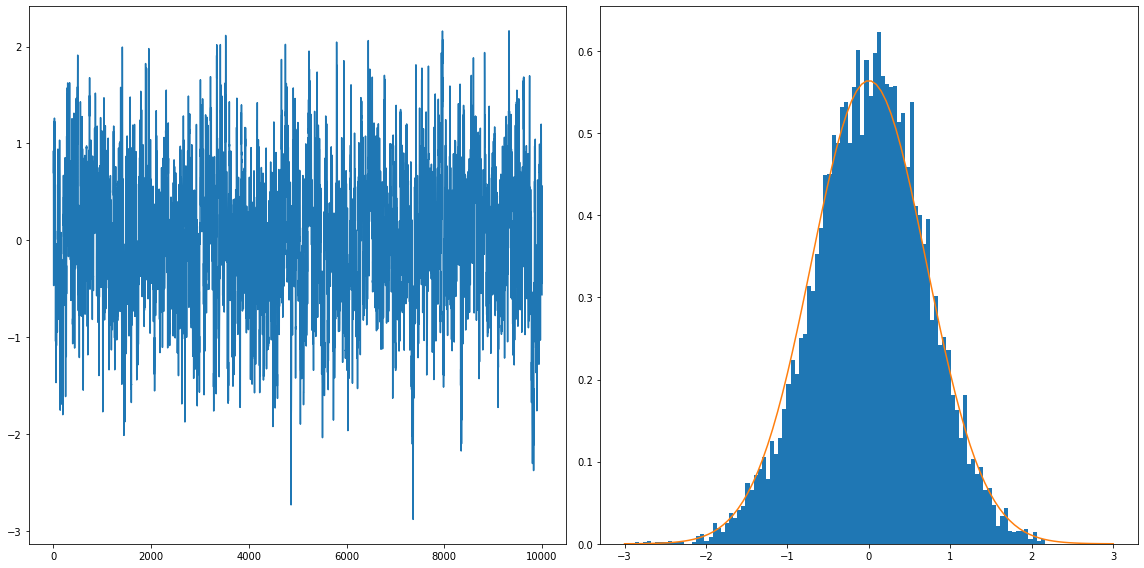

In [31]:
q0 = np.random.uniform()
q=q0
dt = 0.1
N = 10000
nb_rejections = 0
qtrace = np.zeros((N,1))
for n in range(N):
  q,rejection_flag = step_mala(q, dt, beta)
  if rejection_flag: # there was a rejection in MALA
    nb_rejections += 1
  qtrace[n]=q

print("Average rejection rate",nb_rejections*1./N)   
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].plot(qtrace)
axes[1].hist(qtrace, bins=100, density=True)
q=np.linspace(-3,3,100)
axes[1].plot(q, list(map(nu_normed, q)))
fig.tight_layout()

## 1.3. Overdamped Langevin stochastic differential equation

The MALA proposal is derived from a Euler-Maruyama discretization of the the following continuous time process:
$$dq_t = -\nabla V(q_t)\, dt + \sqrt{2\beta^{-1}}dW_t, $$
where $t\mapsto W_t$ is a standard Wiener process. The process above leaves invariant the probability distribution $\mu(q)\propto \exp(-\beta V(q))$. In other words, if $q^0\sim \mu$, then $q^n\sim \mu$, for all $n\geq 0$. Thus, integrating the overdamped Langevin dynamics should provide a sequence of samples distributed according to $\mu$. However, the time-discretization introduced to integrate the EDS induces a bias, and the resulting sequence is not distributed exactly according to $\mu$. This yields the necessity to perform an accept/reject step, in order to correct this bias.

**Question 6:** Below is the code to perform the integration of the overdamped Langevin dynamics **without** the accept/reject step. Run the code for different values of the step size $\Delta t$. What do you observe ?


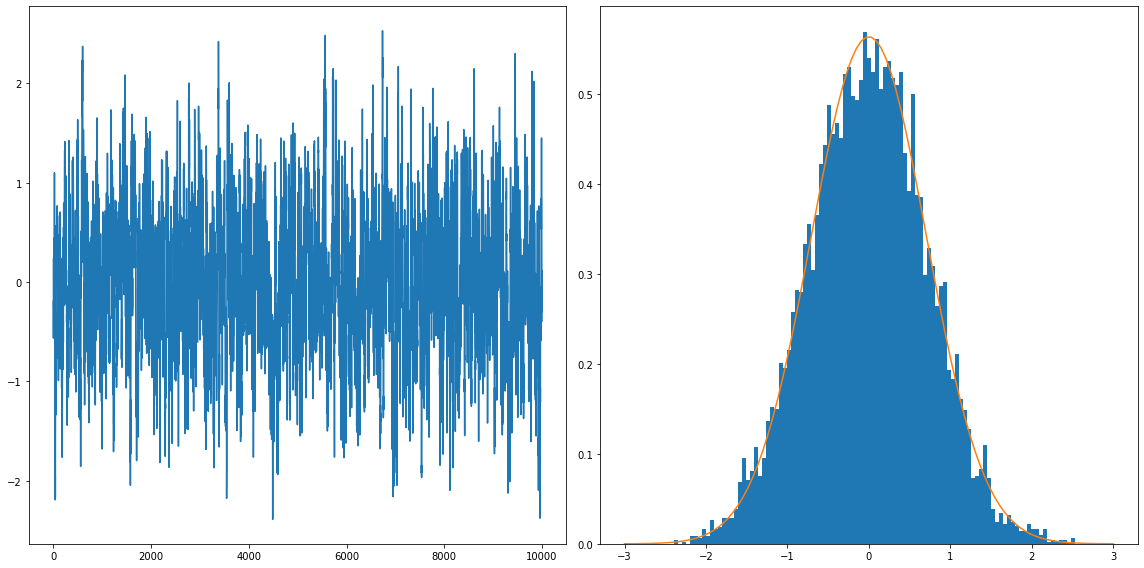

In [32]:
def step_ovdLangevin(q, dt):
  G=np.random.normal(size=1)
  q_tilde = q-dt*gradV(q)+math.sqrt(2*dt/beta)*G
  return q_tilde

q0 = 0
q=q0
dt = 0.1
N = 10000
qtrace = np.zeros((N,1))
for n in range(N):
  q = step_ovdLangevin(q, dt)
  qtrace[n]=q
    
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].plot(qtrace)
axes[1].hist(qtrace, bins=100, density=True)
q=np.linspace(-3,3,100)
axes[1].plot(q, list(map(nu_normed, q)))
fig.tight_layout()

#2. Empirical averages and Central Limit Theorem (CLT)

The main purpose of MCMC sampling is to compute empirical averages of quantities of interest, i.e. macroscopic quantities written as averages over thermodynamic ensembles, which are embodied in the target probability measure $\nu$. Consider an *observable* $\phi:q\mapsto \phi(q)$. MCMC sequences are employed to approximate the average value of $\phi$, 
$$\mathbb{E}_{\nu}[\phi(q)] = \int_{\mathbb{R}}\phi(q)\nu(dq).$$

Approximations are computed through empirical averages: let $q^0,\ldots, q^N$ be a sequence generated by an MCMC algorithm. $\mathbb{E}_{\nu}[\phi(q)]$ is approximated by the following quantity:
$$\hat{\phi}_N = \frac{1}{N}\sum_{n=1}^N\phi(q^n).$$

**Question 7:** Use the MALA sequence generated above in Section 1.2 to compute the empirical average of the position $q$, given by $\hat{q}_N = \frac{1}{N}\sum_{n=1}^Nq^n$, to approximate $\mathbb{E}_{\nu}[q]$. Compute the approximation error $\hat{q}_N-\mathbb{E}_{\nu}[q]$.



In [0]:
nb_realizations=100
emp_average = np.zeros((nb_realizations,1))
dt = 0.1
N = 1250
for i in range(nb_realizations):
  q0 = np.random.uniform()
  q=q0
  # generate a new trajectory
  traj = np.zeros((N,1))
  for n in range(N):
    q,flag = step_mala(q, dt, beta)
    traj[n]=q
  # take empirical average over the trajectory
  emp_average[i] = np.sum(traj)/N


Theoretical average  -0.13941045426849066
Empirical average  -0.14795122467462948
Variance  0.06360852797542277


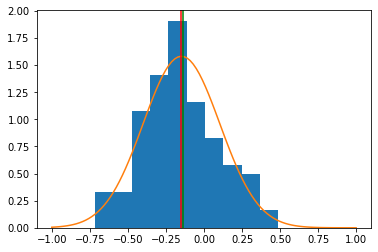

In [18]:
import statistics as stat

E_q = integrate.quad(lambda q: q*nu_normed(q), -3, 3)[0]
print("Theoretical average ",E_q)
Avg_q = np.mean(emp_average)
print("Empirical average ",Avg_q)
Var_q = np.var(emp_average,0)[0]
print("Variance ",Var_q)
from scipy.stats import norm
plt.hist(emp_average, bins=10, density=True)
q=np.linspace(-1,1,100)
def norm_d(q):
  return norm.pdf(q, Avg_q, math.sqrt(Var_q))
plt.plot(q, list(map(norm_d , q)))
plt.axvline(x=E_q, color="green")
plt.axvline(x=Avg_q, color="red")


# 3. Hamiltonian dynamics and Generalized Hamiltonian Monte Carlo (GHMC)

## 3.1 Integration of Hamiltonian dynamics with the Verlet scheme

In this part, we focus on the Hamiltonian dynamic. Let $M$ be the mass of the particle (in the code we always take $M=1$), and $$H(q(t), p(t)) = V(q(t)) + \frac{1}{2}p^{\top}Mp$$ be the Hamiltonian of the system. The Hamiltonian dynamic is given by: 
$$
\begin{aligned}
\frac{d q(t)}{dt} & = \nabla_pH(q(t), p(t)) = M^{-1} p(t), \\ 
\frac{d p(t)}{dt} & = -\nabla_qH(q(t), p(t)) = -\nabla V(q(t)). 
\end{aligned}
$$
To integrate the Hamiltonian dynamic, one may resort to the so-called Verlet scheme. For some time step $\Delta t$, the Verlet scheme updates the position and momentum variables iteratively in three steps starting from the current point $(q^n, p^n)$:


1.   $\displaystyle p^{n+1/2} = p^n - \frac{\Delta t}{2}\nabla V(q^n)$
2.   $\displaystyle q^{n+1} = q^n + \Delta t M^{-1}p^{n+1/2}$
3.   $\displaystyle p^{n+1} = p^{n+1/2} - \frac{\Delta t}{2}\nabla V(q^{n+1})$




In [0]:
def step_Verlet(q, p, dt):
  p_new = p - 0.5*dt*gradV(q)
  q_new = q + dt*p_new
  p_new = p_new - 0.5*dt*gradV(q_new)
  H = V(q_new) + 0.5*p_new**2
  return q_new, p_new, H

One of the fundamental properties of the Hamiltionian dynamics is to preserve the Hamiltonian H. In addition, over a trajectory, the error on the conservation of H induced by the discretization should be of the order of $\mathcal{O}(\Delta t^2)$, as emphasized in the plot below.

**Question 8.** Check numerically these statements.

Energy variation  0.004340379651270432


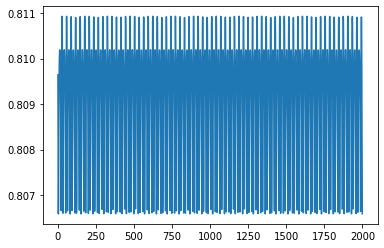

In [50]:
N = 2000
dt = 0.1  

q0 = np.random.uniform()
p0 = np.random.uniform()
q=q0
p=p0 
qtrace = np.zeros((N,1))
Htrace = np.zeros((N,1))
for n in range(N):
  q, p, H = step_Verlet(q, p, dt)
  qtrace[n]=q
  Htrace[n]=H
Hmax = np.amax(Htrace)
Hmin = np.amin(Htrace)
print("Energy variation ",Hmax-Hmin)

plt.plot(Htrace)


## 3.2 Hamiltonian Monte-Carlo 

The Hamiltonian Monte Carlo algorithm corresponds to an instance of the Metropolis–Hastings algorithm, where the proposal is defined through a Hamiltonian dynamics evolution simulated using anumerical integrator (e.g. the leapfrog integrator). As the RWMH and MALA algorithms, it proceeds in two steps. First, from the current state $(q^n, p^n)$, a new state $(\tilde{q}^{n+1}, \tilde{p}^{n+1})$ is proposed according to the Hamiltonian dynamics. Then, an acceptance/rejection step is performed, where the proposed state is accepted with probability
$$r = \min(1, \exp(-\beta(H(\tilde{q}^{n+1}, \tilde{p}^{n+1})- H(q^n, p^n)))) $$

**Question 9.** Test the performance of the algorithm for various choices of $\Delta t$ and $\gamma$. 

**Question 10.** Check that velocities need to be reversed upon rejection (i.e. if this is not done, then there is some bias in the distribution which is sampled).



In [0]:
def step_gHMC(current_q, current_p, dt, gamma, beta):
  rejection = False
  # update velocities by mixing
  alpha = math.exp(-gamma*dt)
  p=alpha*current_p+math.sqrt((1-alpha**2)/beta)*np.random.normal(size=1)
  # keep configuration before Verlet step
  current_p=p
  q=current_q
  # Verlet step
  p=p-dt*gradV(q)/2
  q=q+dt* p
  p=p-dt*gradV(q)/2 
  # compute acceptance rate
  current_H=current_p**2/2+V(current_q)
  proposed_H=p**2/2+V(q)
  r=beta*(current_H- proposed_H)
  # perform Metropolis test
  u=math.log(np.random.uniform(size=1))
  if (u<=r):
    q_next=q
    p_next=p
  else: # reject: beware change of sign for momenta!
    q_next=current_q
    p_next=-current_p
    rejection=True
  return q_next, p_next, rejection



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Rejection rate  0.47671


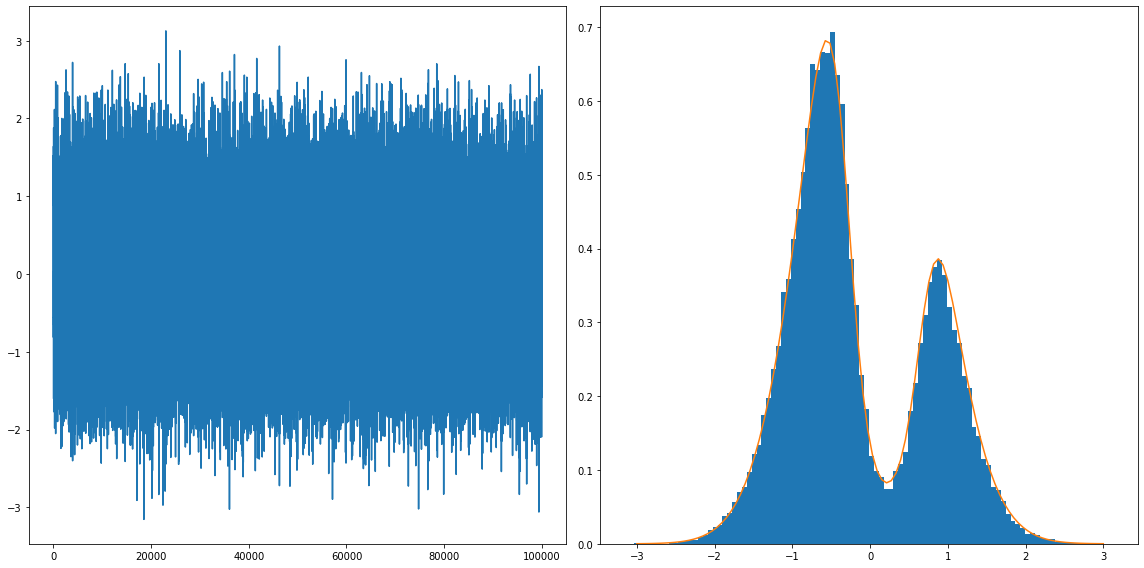

In [61]:
q=np.random.uniform(size=1)
p=np.random.uniform(size=1)
dt = 0.5
gamma = 1
N = 10000
nb_rejections = 0
qtrace = np.zeros((N,1))
ptrace = np.zeros((N,1))
for n in range(N):
  q, p, flag = step_gHMC(q, p, dt, gamma, beta)
  qtrace[n]=q
  if flag:
    nb_rejections += 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].plot(qtrace)
axes[1].hist(qtrace, bins=100, normed=True)
q=np.linspace(-3,3,100)
axes[1].plot(q, list(map(nu_normed, q)))
fig.tight_layout()

print("Rejection rate ",nb_rejections*1./N)


**Additional questions** (if you have finished...) \\
1 - Implement the discretization of the underdamped Langevin dynamics we have seen during the lectures \\
2 - Implement proposal for MALA based on moves with a position-dependent variance, i.e. $\widetilde{q}^{n+1} = q^n + \left(- \sigma^2(q^n) \nabla V(q^n) + \sigma(q^n)\sigma'(q^n) \right) \Delta t + \sigma(q^n) \sqrt{\Delta t} \, G^n $ for a given scalar valued function $\sigma(q)$ uniformly bounded from below by a positive constant (for instance, $\sigma(q) = (2+\cos(q))/3$). \\
3 - Implement importance sampling based on a modified potential $$\widetilde{V}_a(q) = \frac{a}{\sqrt{2\pi w}}\exp\left(-\frac{(q-c)^2}{2w}\right)$$ for some parameter $a \geq 0$